## Integrating Planning into RL methods via Dyna
### BlackJack

- Aaron Dharna

In [1]:
from collections import defaultdict
from collections import namedtuple
import numpy as np
import sys
import gym
import copy

In [2]:
from plot_utils import plot_blackjack_values
from plot_utils import plot_policy
import matplotlib.pyplot as plt

In [3]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```

In [4]:
#Helper functions for Q learning.

def e_greedy_policy_creation(Qstate, epsilon, nA):
    """
    Q: Our Q table. 
      Q[state] = numpy.array
      Q[state][action] = float.
    epsilon: small value that controls exploration.
    nA: the number of actions available in this environment
    
    return: an epsilon-greedy policy specific to the state.
    """
    
    policy = np.ones(nA) * epsilon/nA
    policy[np.argmax(Qstate)] = 1 - epsilon + (epsilon / nA)        
    return policy

In [5]:
def choose_action(policy, env):
    return np.random.choice(np.arange(env.action_space.n), p=policy)

> In this chapter we develop a unified view of reinforcement learning methods that require a model of the environment, such as dynamic programming and heuristic search, and methods that can be used without a model, such as Monte Carlo and temporal-difference methods. These are respectively called model-based and model-free reinforcement learning methods. Model-based methods rely on planning as their primary component, while model-free methods primarily rely on learning.

# Dyna: Integrated Planning, Acting, and Learning


Given a state and an action, a `model`, M, produces a prediction of the resultant next state and next reward. The model-learning method is also table-based and assumes the environment is deterministic. After each transition $S_t, A_t \rightarrow R_{t+1}, S_{t+1}$,the model records in its table entry for $S_t$, $A_t$ the prediction that $R_{t+1},S_{t+1}$ will deterministically follow. Thus, if the model is queried with a state–action pair that has been experienced before, it simply returns the last-observed next state and next reward as its prediction.

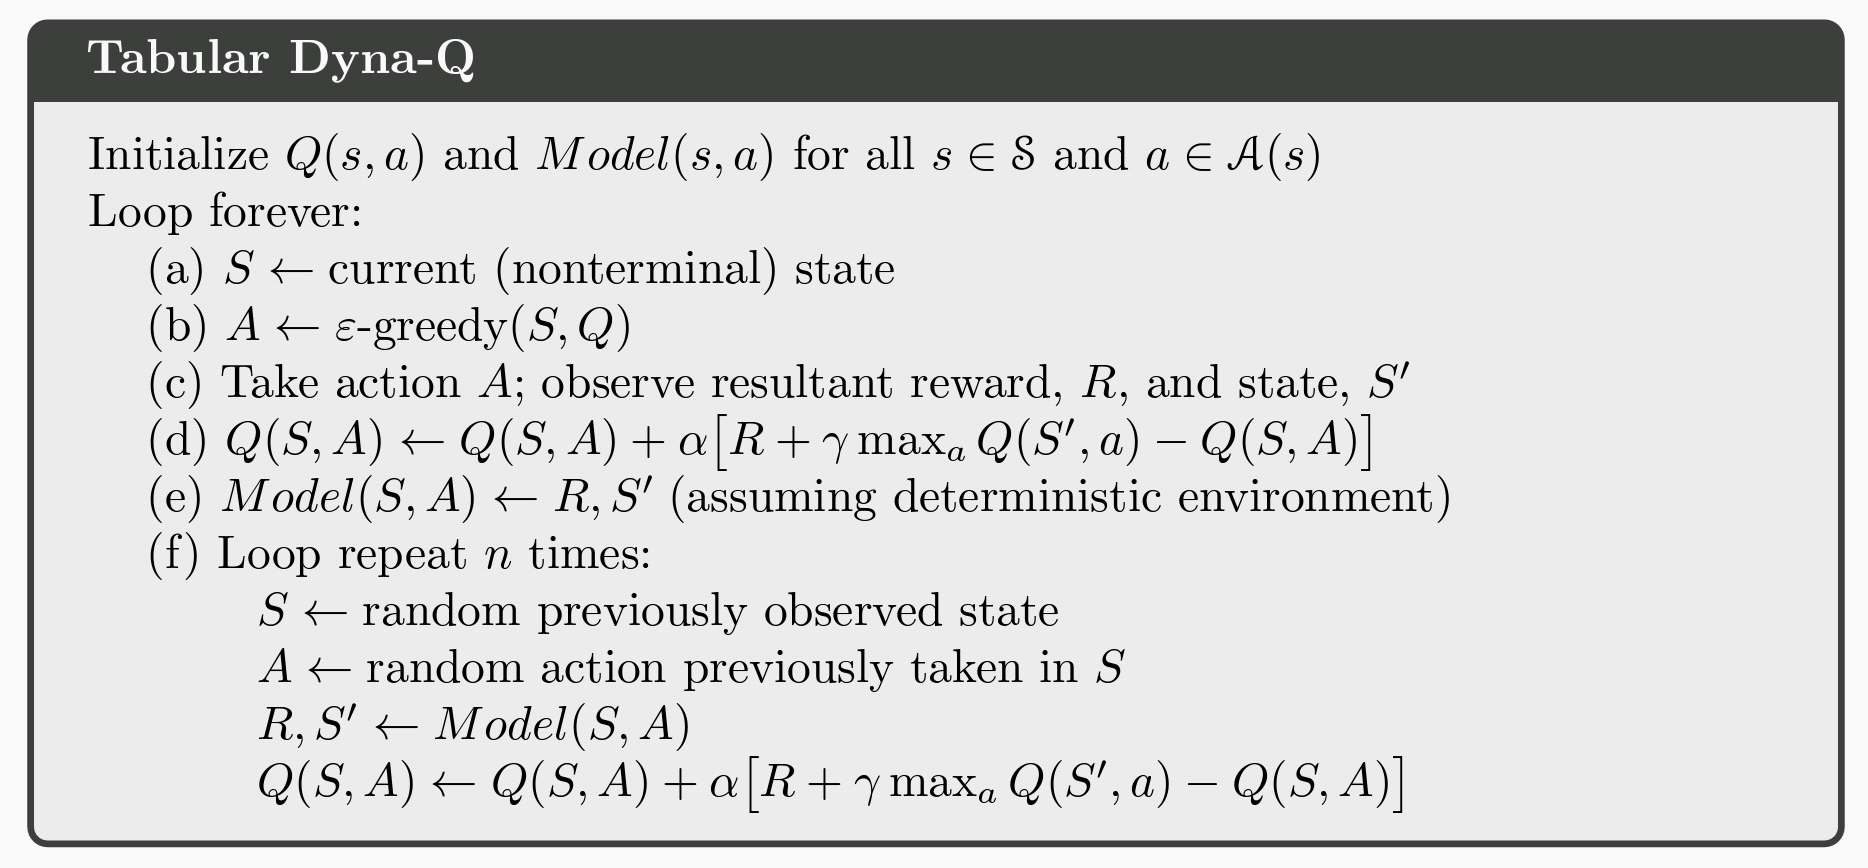

----

`tPlusOne` is simply a namedtuple so that we can easily store resultant states and rewards for our model.

In [ ]:
tPlusOne = namedtuple('prediction', ['next_state', 'reward'])

# TabularDynaQ

- `env` openAi blackjack env 
- `depth` planning parameter
- `num_episodes` number of games of blackjack to play
- `alpha` step-size paramater for Q learning
- `gamma` future-reward discount parameter


In [ ]:
def tabularDynaQ(env, depth, num_episodes, alpha, gamma=1):
    nA = env.action_space.n
    # initialize action-value function (empty dictionary of arrays)    
    Q = defaultdict(lambda: np.zeros(nA))
    # initialize model of env
    M = defaultdict(lambda: tPlusOne('s', 'r'))
    for i_episode in range(1, num_episodes+1):     
        
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush() 
        
        state = env.reset()
        epsilon = 0.1

        while True:

            policy = e_greedy_policy_creation(Q[state], epsilon, nA)
            action = choose_action(policy, env)
            sPrime, reward, done, info = env.step(action)
            policy = e_greedy_policy_creation(Q[sPrime], epsilon, nA)
            Q[state][action] += alpha * (reward + (gamma * np.max(Q[sPrime])) - Q[state][action])
            M[(state, action)] = tPlusOne(sPrime, reward)
            state = sPrime

            for _ in range(depth):
                index = np.random.choice(range(len(M.keys())))
                hand, act = list(M.keys())[index]
                sP, reward = M[(hand, act)]
                Q[hand][act] += alpha * (reward + (gamma * np.max(Q[sP])) - Q[hand][act])

            if done:
                break
    return Q, M

## Our visualization function will take in: 

- `depth` for how long do we want to plan?
- `num_episodes` how many games of blackjack do we want to play?
- `alpha` step-size parameter
- `gamma` decay factor

The function will display three plots: 
    - value when holding an ace of a given hand
    - value when not holding as ace of a given hand
    - the derived policy

In [ ]:
def runAndVisualizeDynaQ(depth, num_episodes, alpha, gamma):
    Q_dyna, model = tabularDynaQ(env, depth, num_episodes, alpha, gamma)

    # obtain the state-value function
    V_Dyna = dict((k,np.max(v)) for k, v in Q_dyna.items())

    # plot the state-value function
    plot_blackjack_values(V_Dyna)

    policy = dict((k,np.argmax(v)) for k, v in Q_dyna.items())

    plot_policy(policy)

----

----

# The Optimal Solution for Blackjack from S&B:

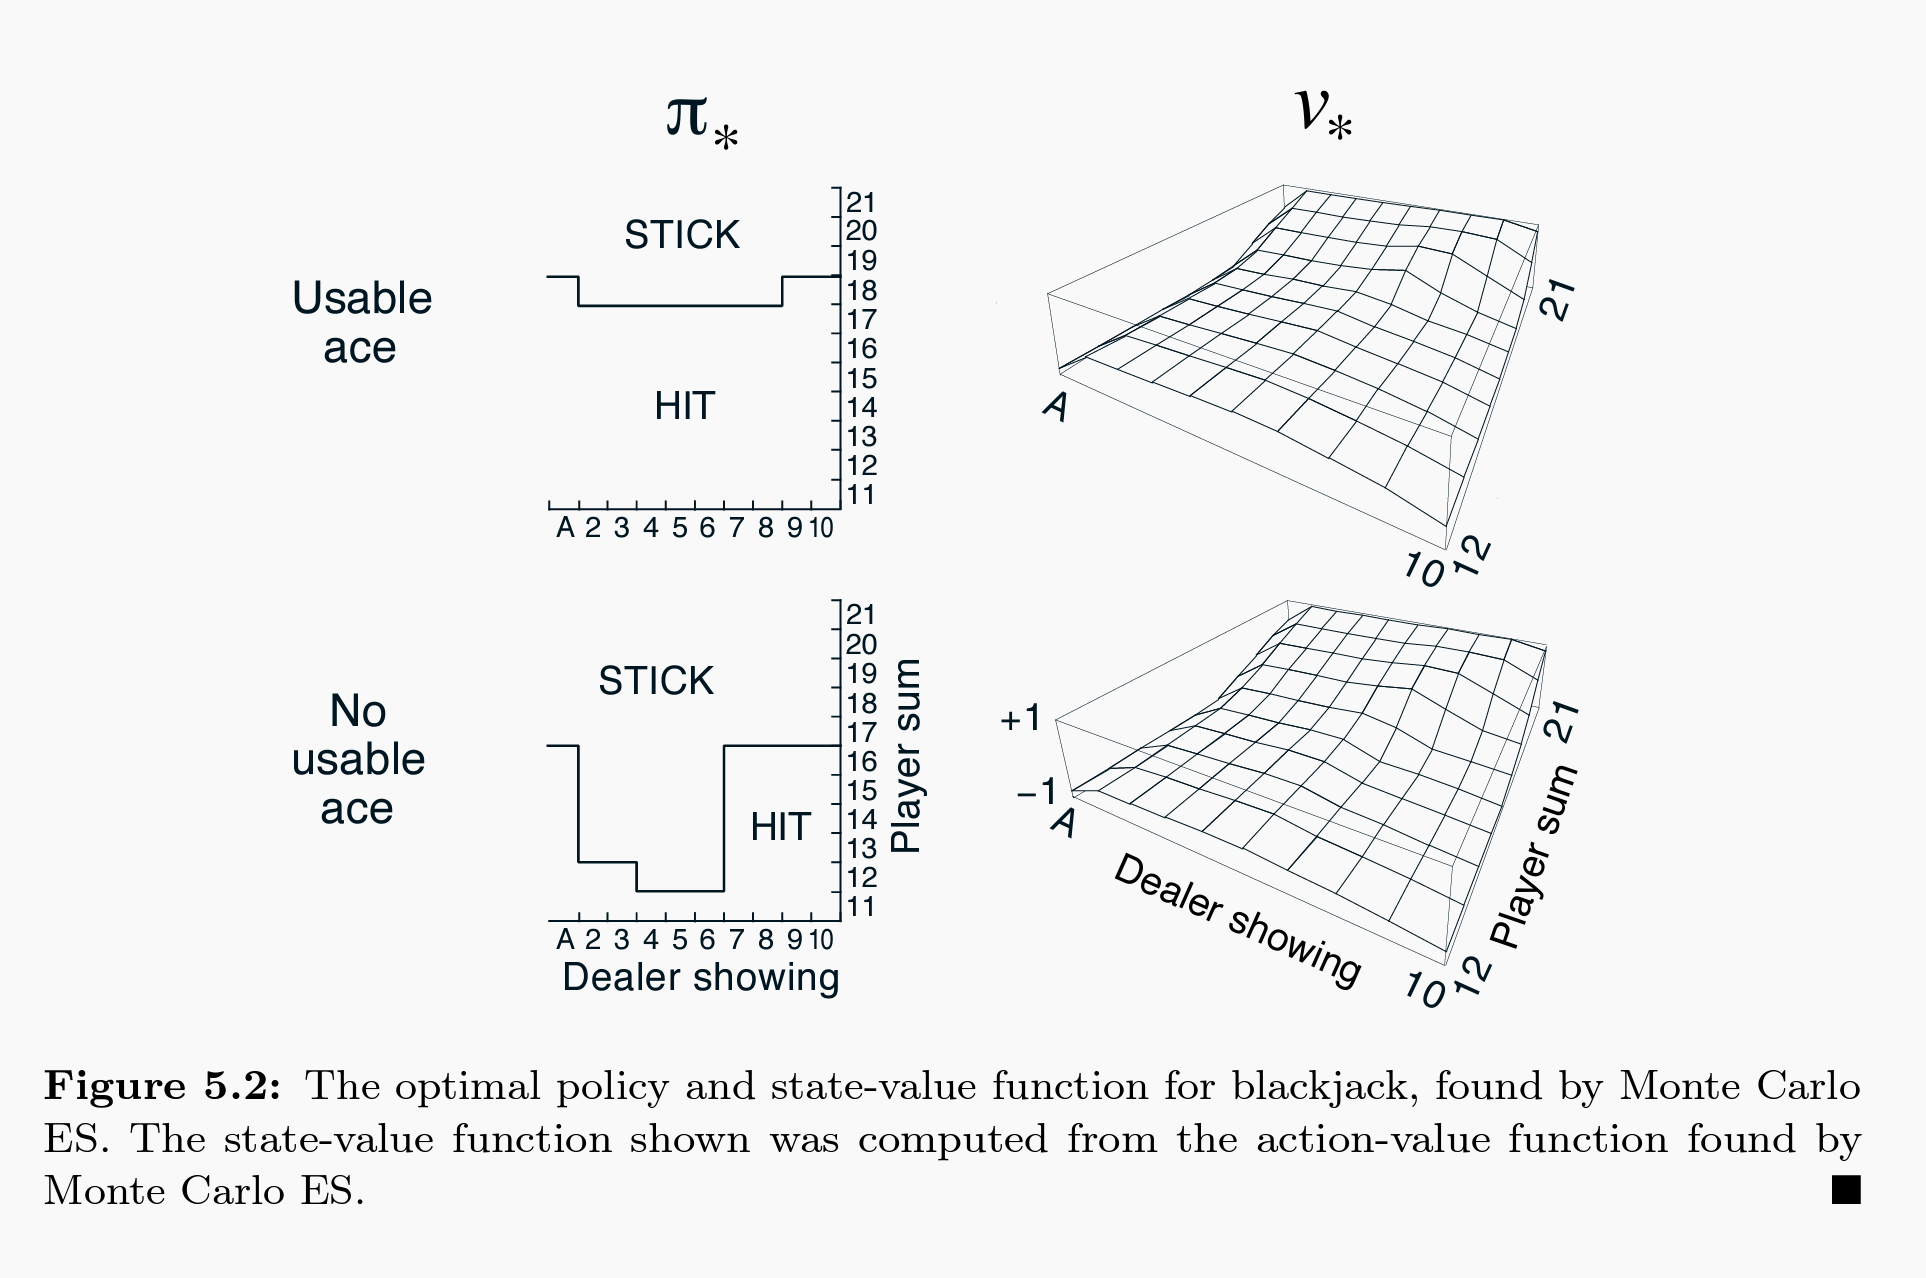

----

----

# Testing DynaQ

----

First up, is regular Q-learning. We're giving this one a really long episode count since this will only be able to udpate once cell per episode. Ideally, this will converge to the optimal solution (and it just about does).

In [ ]:
runAndVisualizeDynaQ(0, 500000, .001, 0.01)

While this is not quite optimal, it is very close. A longer episode length would probably make it match exactly. 

----

Now, what if we introduce planning? The experiment that seems the most natrual to start is: what if we have a few planning steps, say 10, and bring down our episodes down, say 100000?

In [ ]:
runAndVisualizeDynaQ(10, 100000, .001, 0.25)

This is close! So, lets try increasing depth and decreasing episodes even further!

----

In [ ]:
runAndVisualizeDynaQ(25, 25000, .001, 0.25)

If we look at the value-function plot, we're clearly losing clarity here; however, let's drastically increasing the planning parameter and decrease the episode lengths further. 

----

In [ ]:
runAndVisualizeDynaQ(100, 15000, .001, 0.25)

Since it seems that we've pushed the planning too far, I'm going to go back to `runAndVisualizeDynaQ(25, 25000, .001, 0.01)` and increase the number of episodes. 10 and 100000 did pretty well as depth and episodes, therefore, let's match the episode count and increase the planning.  

In [ ]:
runAndVisualizeDynaQ(25, 100000, .001, 0.25)

One reason that we could be doing a poor job of converging onto Q-learning's answer is because our model -- $S_t, A_t \rightarrow R_{t+1}, S_{t+1}$, -- is inherently kinda bad. If we wanted to imporve our model we could instead capture a probability that we go bust from that position. But then we've kind of infringed upon what the value function is supposed to be doing. 

----

----

# Moving forward to Monte-Carlo Tree Search.

In [6]:
def generate_episode_from_policy_and_state(env, policy, state):
    episode = []
    #?? This shouldn't reset here since we want to go from the given state
    # I should probably break into the blackjack env to see how they do env.step(action).
    #print(state)
    state = env.reset_to_state(state)
    while True:
        action = choose_action(policy, env)
        next_state, reward, done, info = env.step(action) #?? 
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [7]:
class Node:
    def __init__(self, state, action, value):
        self.children = {}
        self.state = state
        self.action = action
        self.value = value
        self.parent = -1
        
    def isBarren(self):
        return True if len(self.children) == 0 else False
    
    def addChild(self, state, action, value):
        self.children[state] = Node(state, action, value)
        self.children[state].parent = self.state
        
    def __str__(self):
        s = "children: {}".format(self.children)
        return s


In [50]:
class MCTS:
    """ Implmentation of UCB MCTS in Blackjack """
    def __init__(self):
        self.root = defaultdict(lambda: Node((0, 0, False), 0, 0))
        self.initial_state = env.reset()
        self.root[self.initial_state] = Node(self.initial_state, 0, 0)
        self.rolloutPolicy = None
        self.Q = defaultdict(lambda: np.ones(2)/2)
        self.UCB_C = 2
        self.timeStep = 0
        self.kAction = np.zeros(2)
        self.epsilon = 1 / (self.timeStep + 1)
        self.gamma = 1
        self.alpha = 1e-3
        
    def UCB_action_choice(self, state):
        #avoid 0/0 with time + 1 and kAction + delta
        UCB_estimation = self.Q[state] + \
                         self.UCB_C * (np.sqrt(np.log(self.timeStep + 1) / (self.kAction + 1e-5)))

        #find the best action
        action_max = np.argmax(UCB_estimation)
                
        #if multiple actions are the best, chose randomly
        other_choices = []
        for action, q in enumerate(UCB_estimation):
            #this will contain action_max
            if q == UCB_estimation[action_max]:
                other_choices.append(action)

        a = np.random.choice(other_choices)
        
        self.kAction[a] += 1
        self.timeStep += 1

        return a
    
    def findNodeLocation(self, root, nodeId):
        n = None
        if root.state == nodeId:
            return root
        for k in root.children:
            ans = self.findNodeLocation(root.children[k], nodeId)
            if not ans == None:
                n = ans
        return n
    
    def addChild(self, action, parent, chain):
        new_state, reward = self.get_new_state(parent.state, action)
        parent.addChild(new_state, action, reward)
        chain.append((parent.state, action, reward))
    
    def get_new_state(self, state, action):
        #will need a slightly different version of step. same as above. 
        #new_state, reward, done, info = self.env.act(action)
        #print(state, action)
        state = env.reset_to_state(state)
        next_state, reward, done, info = env.step(action)
        
        return next_state, reward   
    
    def deconstruct(self, root, leaves):
        """ Starting at the root node, a tree policy based on the action values attached 
        to the edges of the tree traverses the tree to select a leaf node """
        leaves[root.state] = list(root.children)

        for k in root.children:
            self.deconstruct(root.children[k], leaves)
    
    def follow_tree_policy(self, root, leaves, chain):
        """ Apply UCB at each node in the tree to move to the next node """
        if root.state in leaves:
            return root.state
        
        action = self.UCB_action_choice(root.state)
        chain.append((root.state, action, root.value))
        
        leaf = root.state
        
        for k in root.children:
            if action == root.children[k].action:
                leaf = self.follow_tree_policy(root.children[k], leaves, chain)
        
        return leaf
        
    
    def selection(self, root, chain):
        """ Starting at the root node, a tree policy based on the action values attached 
        to the edges of the tree traverses the tree to select a leaf node """
        #find leaf/unexplored states
        
        l = {}
        self.deconstruct(root, l)
        leaves = []
        for k in l:
            #if it has zero or one children, this node is a possible terminal node.
            if len(l[k]) <= 1:
                leaves.append(k)
        
        chain.append((self.initial_state, 0, 0))
        leaf = self.follow_tree_policy(root, leaves, chain) 
        #print(leaf)
        return leaf
    
    def expansion(self, stateId, chain):
        """ For the chosen state, choose an action to expand the tree from """
        parentNode = self.findNodeLocation(self.root[self.initial_state], stateId)
        if parentNode is None:
            raise Exception("node: {} is not in tree".format(stateId))
        #print(parentNode.state)
        a = self.UCB_action_choice(parentNode.state)
        #print(a)
        
        self.addChild(a, parentNode, chain)
        return parentNode
    
    def simulation(self, numSims, leaf):
        """ rollout algorithm """
        episodes = []
        for i in range(numSims):
            episodes.append(generate_episode_from_policy_and_state(env, self.rolloutPolicy, leaf))
        return episodes
    
    def backup(self, chain):
        """ backup the value we calculated from the rollout """
        
        seen = []

        for t, (state, action, reward) in enumerate(chain):
            if state not in seen:
                seen.append(state)
                G = 0
                                
                for fi, (fstate, faction, freward) in enumerate(chain[t:]):
                    G += (self.gamma**fi)*freward
                
                self.Q[state][action] += self.alpha*(G - self.Q[state][action])
        
        return
    
    def MC(self, startState):
        """ do all the steps for MCTS """
        
        chain = []
        
        #select a leaf node
        state = self.selection(m.root[self.initial_state], chain)
                
        #expand that leaf node
        leaf = self.expansion(state, chain)
        
        #generate a rolloutPolicy for said leaf node
        # However, why should that be used at each step of the rollout?
        # I don't think it should be. 
        self.rolloutPolicy = e_greedy_policy_creation(self.Q[leaf.state], self.epsilon, 2)
        
        #simulate a bunch of MC episodes to get value of said state
        episode = self.simulation(100, leaf.state)
        
        #remove placeholder starting state from chain
        chain.remove(chain[0])
        
        for e in episode:
            c = copy.deepcopy(chain)
            c.extend(e)
            #print(c)
            self.backup(c)
        
        return

In [51]:
m = MCTS()

In [55]:
m.initial_state

(20, 1, True)

In [53]:
for _ in range(100):
    m.MC(m.initial_state)

In [54]:
m.Q

defaultdict(<function __main__.MCTS.__init__.<locals>.<lambda>()>,
            {(20, 1, True): array([-0.30950191, -0.17907185]),
             (12, 1, False): array([0.25131158, 0.25160203]),
             (16, 1, False): array([0.25184599, 0.25790662]),
             (13, 1, False): array([0.2440534 , 0.28332878]),
             (20, 1, False): array([ 0.30288165, -0.31868004]),
             (18, 1, False): array([0.3259459 , 0.18753364]),
             (14, 1, False): array([0.25446493, 0.25544165]),
             (17, 1, False): array([0.27040208, 0.22939178]),
             (15, 1, False): array([0.25618835, 0.236023  ]),
             (21, 1, False): array([0.51529045, 0.31179714]),
             (21, 1, True): array([0.51509499, 0.32335368]),
             (19, 1, False): array([0.35407434, 0.14717208])})

# Integrating MCTS into Dyna